## MIMICIII Mechanical Ventilation MAgECs

In [1]:
import numpy as np
import pandas as pd
import psycopg2
import os 
import random
import datetime
from sqlalchemy import create_engine
import matplotlib.pyplot as plt

%matplotlib inline

random.seed(22891)

In [2]:
pd.set_option('display.max_columns', None)

### Get data

In [3]:
# information used to create a database connection
sqluser = 'postgres'
dbname = 'mimic'
schema_name = 'mimiciii'

engine = create_engine("postgresql+psycopg2://{}:{}@/{}".format(sqluser, sqluser, dbname))

schema_name = 'mimiciii'
conn = engine.connect()
conn.execute('SET search_path to ' + schema_name)

df = pd.read_sql("SELECT * FROM mimic_users_study;", conn)
conn.close()

### Timepoint represents hours prior to event (order in descending order)

In [4]:
df = df.sort_values(['subject_id', 'timepoint'], ascending=(1,0))

In [5]:
df.head()

,subject_id,hadm_id,icustay_id,timepoint,event_time,ventilated,mv_start,aniongap,albumin,bicarbonate,bilirubin,creatinine,chloride,glucose,hematocrit,hemoglobin,lactate,magnesium,phosphate,platelet,potassium,ptt,inr,pt,sodium,bun,wbc,heartrate_mean,sysbp_mean,diasbp_mean,meanbp_mean,resprate_mean,tempc_mean,spo2_mean,glucose_mean,age,first_icu_stay,adult_icu,first_careunit,diagnosis,curr_service,dischtime,admission_type,mort_icu,gender,admittime,los_icu,mv_hours,los_icu_hr,mv_end,los_hospital,first_hosp_stay,outtime,intime,ventnum,prev_service,transfertime,ethnicity,congestive_heart_failure,cardiac_arrhythmias,valvular_disease,pulmonary_circulation,peripheral_vascular,hypertension,paralysis,other_neurological,chronic_pulmonary,diabetes_uncomplicated,diabetes_complicated,hypothyroidism,renal_failure,liver_disease,peptic_ulcer,aids,lymphoma,metastatic_cancer,solid_tumor,rheumatoid_arthritis,coagulopathy,obesity,weight_loss,fluid_electrolyte,blood_loss_anemia,deficiency_anemias,alcohol_abuse,drug_abuse,psychoses,depression
23,4,185777,294638,26,2191-03-17 03:29:31,0,NaT,17.0,2.8,24.0,2.2,0.5,97.0,140.0,34.2,11.5,2.1,1.9,3.2,207.0,3.1,31.3,1.0,12.3,135.0,9.0,9.7,111.0,NaN,NaN,NaN,NaN,37.444445,98.0,NaN,47.0,1,1,MICU,"FEVER,DEHYDRATION,FAILURE TO THRIVE",MED,2191-03-23 18:41:00,EMERGENCY,0,0,2191-03-16 00:28:00,1.0,NaN,40.0,NaT,7.0,1,2191-03-17 16:46:31,2191-03-16 00:29:31,NaN,None,2191-03-16 00:29:31,white,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
22,4,185777,294638,25,2191-03-17 03:29:31,0,NaT,17.0,2.8,24.0,2.2,0.5,97.0,140.0,34.2,11.5,2.1,1.9,3.2,207.0,3.1,31.3,1.0,12.3,135.0,9.0,9.7,100.0,116.0,63.0,80.666702,NaN,NaN,98.0,NaN,47.0,1,1,MICU,"FEVER,DEHYDRATION,FAILURE TO THRIVE",MED,2191-03-23 18:41:00,EMERGENCY,0,0,2191-03-16 00:28:00,1.0,NaN,40.0,NaT,7.0,1,2191-03-17 16:46:31,2191-03-16 00:29:31,NaN,None,2191-03-16 00:29:31,white,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
21,4,185777,294638,24,2191-03-17 03:29:31,0,NaT,17.0,2.8,24.0,2.2,0.5,97.0,140.0,34.2,11.5,2.1,1.9,3.2,207.0,3.1,31.3,1.0,12.3,135.0,9.0,9.7,88.0,NaN,NaN,NaN,NaN,NaN,99.0,NaN,47.0,1,1,MICU,"FEVER,DEHYDRATION,FAILURE TO THRIVE",MED,2191-03-23 18:41:00,EMERGENCY,0,0,2191-03-16 00:28:00,1.0,NaN,40.0,NaT,7.0,1,2191-03-17 16:46:31,2191-03-16 00:29:31,NaN,None,2191-03-16 00:29:31,white,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
20,4,185777,294638,23,2191-03-17 03:29:31,0,NaT,17.0,2.8,24.0,2.2,0.5,97.0,140.0,34.2,11.5,2.1,1.9,3.2,207.0,3.1,31.3,1.0,12.3,135.0,9.0,9.7,80.0,101.0,57.0,71.666702,NaN,NaN,100.0,NaN,47.0,1,1,MICU,"FEVER,DEHYDRATION,FAILURE TO THRIVE",MED,2191-03-23 18:41:00,EMERGENCY,0,0,2191-03-16 00:28:00,1.0,NaN,40.0,NaT,7.0,1,2191-03-17 16:46:31,2191-03-16 00:29:31,NaN,None,2191-03-16 00:29:31,white,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
19,4,185777,294638,22,2191-03-17 03:29:31,0,NaT,17.0,2.8,24.0,2.2,0.5,97.0,140.0,34.2,11.5,2.1,1.9,3.2,207.0,3.1,31.3,1.0,12.3,135.0,9.0,9.7,74.0,101.0,61.0,74.333298,NaN,NaN,100.0,179.333333,47.0,1,1,MICU,"FEVER,DEHYDRATION,FAILURE TO THRIVE",MED,2191-03-23 18:41:00,EMERGENCY,0,0,2191-03-16 00:28:00,1.0,NaN,40.0,NaT,7.0,1,2191-03-17 16:46:31,2191-03-16 00:29:31,NaN,None,2191-03-16 00:29:31,white,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### Featurize

In [6]:
vitals = ['heartrate_mean', 'sysbp_mean', 'diasbp_mean', 'meanbp_mean',
          'resprate_mean', 'tempc_mean', 'spo2_mean', 'glucose_mean']
labs = ['aniongap', 'albumin', 'bicarbonate', 'bilirubin', 'creatinine', 
        'chloride', 'glucose', 'hemoglobin', 'lactate', 
        'magnesium', 'phosphate', 'platelet', 'potassium', 'ptt', 'inr', 
        'pt', 'sodium', 'bun', 'wbc']  # -hematocrit
comobs = ['congestive_heart_failure', 'chronic_pulmonary', 'pulmonary_circulation']
others = ['age', 'gender']

In [7]:
def last_val(x):
    vals = x[~np.isnan(x)]
    if len(vals):
        return vals[-1]
    else:
        return None
    
def featurize_time(df):
    out = dict()
    for i in range(len(df)):
        for lab in labs:
            val = last_val(df[lab].values[:i+1])
            if lab not in out:
                out[lab] = [val]
            else:
                out[lab].append(val)
        for vital in vitals:    
            val = last_val(df[vital].values[:i+1])
            if vital not in out:
                out[vital] = [val]
            else:
                out[vital].append(val)
        for comob in comobs:    
            val = last_val(df[comob].values[:i+1])
            if comob not in out:
                out[comob] = [val]
            else:
                out[comob].append(val)
        for other in others:
            val = last_val(df[other].values[:i+1])
            if other not in out:
                out[other] = [val]
            else:
                out[other].append(val)
        out['timepoint'] = df.timepoint.values
        out['label'] = [int(x) for x in df.ventilated.values]
    return pd.Series(out)

def featurize(df):
    out = dict()
    for lab in labs:
        out[lab] = last_val(df[lab])
    for vital in vitals:
        out[vital] = last_val(df[vital])
    for comob in comobs:
        out[comob] = last_val(df[comob])
    for other in others:
        out[other] = last_val(df[other])
    out['label'] = int(df.ventilated.iloc[-1])
    return pd.Series(out)

### Example from 'original' dataframe

In [8]:
df[df['subject_id']==4].head()

,subject_id,hadm_id,icustay_id,timepoint,event_time,ventilated,mv_start,aniongap,albumin,bicarbonate,bilirubin,creatinine,chloride,glucose,hematocrit,hemoglobin,lactate,magnesium,phosphate,platelet,potassium,ptt,inr,pt,sodium,bun,wbc,heartrate_mean,sysbp_mean,diasbp_mean,meanbp_mean,resprate_mean,tempc_mean,spo2_mean,glucose_mean,age,first_icu_stay,adult_icu,first_careunit,diagnosis,curr_service,dischtime,admission_type,mort_icu,gender,admittime,los_icu,mv_hours,los_icu_hr,mv_end,los_hospital,first_hosp_stay,outtime,intime,ventnum,prev_service,transfertime,ethnicity,congestive_heart_failure,cardiac_arrhythmias,valvular_disease,pulmonary_circulation,peripheral_vascular,hypertension,paralysis,other_neurological,chronic_pulmonary,diabetes_uncomplicated,diabetes_complicated,hypothyroidism,renal_failure,liver_disease,peptic_ulcer,aids,lymphoma,metastatic_cancer,solid_tumor,rheumatoid_arthritis,coagulopathy,obesity,weight_loss,fluid_electrolyte,blood_loss_anemia,deficiency_anemias,alcohol_abuse,drug_abuse,psychoses,depression
23,4,185777,294638,26,2191-03-17 03:29:31,0,NaT,17.0,2.8,24.0,2.2,0.5,97.0,140.0,34.2,11.5,2.1,1.9,3.2,207.0,3.1,31.3,1.0,12.3,135.0,9.0,9.7,111.0,NaN,NaN,NaN,NaN,37.444445,98.0,NaN,47.0,1,1,MICU,"FEVER,DEHYDRATION,FAILURE TO THRIVE",MED,2191-03-23 18:41:00,EMERGENCY,0,0,2191-03-16 00:28:00,1.0,NaN,40.0,NaT,7.0,1,2191-03-17 16:46:31,2191-03-16 00:29:31,NaN,None,2191-03-16 00:29:31,white,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
22,4,185777,294638,25,2191-03-17 03:29:31,0,NaT,17.0,2.8,24.0,2.2,0.5,97.0,140.0,34.2,11.5,2.1,1.9,3.2,207.0,3.1,31.3,1.0,12.3,135.0,9.0,9.7,100.0,116.0,63.0,80.666702,NaN,NaN,98.0,NaN,47.0,1,1,MICU,"FEVER,DEHYDRATION,FAILURE TO THRIVE",MED,2191-03-23 18:41:00,EMERGENCY,0,0,2191-03-16 00:28:00,1.0,NaN,40.0,NaT,7.0,1,2191-03-17 16:46:31,2191-03-16 00:29:31,NaN,None,2191-03-16 00:29:31,white,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
21,4,185777,294638,24,2191-03-17 03:29:31,0,NaT,17.0,2.8,24.0,2.2,0.5,97.0,140.0,34.2,11.5,2.1,1.9,3.2,207.0,3.1,31.3,1.0,12.3,135.0,9.0,9.7,88.0,NaN,NaN,NaN,NaN,NaN,99.0,NaN,47.0,1,1,MICU,"FEVER,DEHYDRATION,FAILURE TO THRIVE",MED,2191-03-23 18:41:00,EMERGENCY,0,0,2191-03-16 00:28:00,1.0,NaN,40.0,NaT,7.0,1,2191-03-17 16:46:31,2191-03-16 00:29:31,NaN,None,2191-03-16 00:29:31,white,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
20,4,185777,294638,23,2191-03-17 03:29:31,0,NaT,17.0,2.8,24.0,2.2,0.5,97.0,140.0,34.2,11.5,2.1,1.9,3.2,207.0,3.1,31.3,1.0,12.3,135.0,9.0,9.7,80.0,101.0,57.0,71.666702,NaN,NaN,100.0,NaN,47.0,1,1,MICU,"FEVER,DEHYDRATION,FAILURE TO THRIVE",MED,2191-03-23 18:41:00,EMERGENCY,0,0,2191-03-16 00:28:00,1.0,NaN,40.0,NaT,7.0,1,2191-03-17 16:46:31,2191-03-16 00:29:31,NaN,None,2191-03-16 00:29:31,white,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
19,4,185777,294638,22,2191-03-17 03:29:31,0,NaT,17.0,2.8,24.0,2.2,0.5,97.0,140.0,34.2,11.5,2.1,1.9,3.2,207.0,3.1,31.3,1.0,12.3,135.0,9.0,9.7,74.0,101.0,61.0,74.333298,NaN,NaN,100.0,179.333333,47.0,1,1,MICU,"FEVER,DEHYDRATION,FAILURE TO THRIVE",MED,2191-03-23 18:41:00,EMERGENCY,0,0,2191-03-16 00:28:00,1.0,NaN,40.0,NaT,7.0,1,2191-03-17 16:46:31,2191-03-16 00:29:31,NaN,None,2191-03-16 00:29:31,white,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
df[df['subject_id']==4].tail()

,subject_id,hadm_id,icustay_id,timepoint,event_time,ventilated,mv_start,aniongap,albumin,bicarbonate,bilirubin,creatinine,chloride,glucose,hematocrit,hemoglobin,lactate,magnesium,phosphate,platelet,potassium,ptt,inr,pt,sodium,bun,wbc,heartrate_mean,sysbp_mean,diasbp_mean,meanbp_mean,resprate_mean,tempc_mean,spo2_mean,glucose_mean,age,first_icu_stay,adult_icu,first_careunit,diagnosis,curr_service,dischtime,admission_type,mort_icu,gender,admittime,los_icu,mv_hours,los_icu_hr,mv_end,los_hospital,first_hosp_stay,outtime,intime,ventnum,prev_service,transfertime,ethnicity,congestive_heart_failure,cardiac_arrhythmias,valvular_disease,pulmonary_circulation,peripheral_vascular,hypertension,paralysis,other_neurological,chronic_pulmonary,diabetes_uncomplicated,diabetes_complicated,hypothyroidism,renal_failure,liver_disease,peptic_ulcer,aids,lymphoma,metastatic_cancer,solid_tumor,rheumatoid_arthritis,coagulopathy,obesity,weight_loss,fluid_electrolyte,blood_loss_anemia,deficiency_anemias,alcohol_abuse,drug_abuse,psychoses,depression
4,4,185777,294638,7,2191-03-17 03:29:31,0,NaT,17.0,2.8,24.0,2.2,0.5,97.0,140.0,34.2,11.5,2.1,1.9,3.2,207.0,3.1,31.3,1.0,12.3,135.0,9.0,9.7,89.0,139.0,81.0,100.333000,25.0,NaN,97.0,NaN,47.0,1,1,MICU,"FEVER,DEHYDRATION,FAILURE TO THRIVE",MED,2191-03-23 18:41:00,EMERGENCY,0,0,2191-03-16 00:28:00,1.0,NaN,40.0,NaT,7.0,1,2191-03-17 16:46:31,2191-03-16 00:29:31,NaN,None,2191-03-16 00:29:31,white,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,185777,294638,6,2191-03-17 03:29:31,0,NaT,17.0,2.8,24.0,2.2,0.5,97.0,140.0,34.2,11.5,2.1,1.9,3.2,207.0,3.1,31.3,1.0,12.3,135.0,9.0,9.7,92.0,NaN,NaN,NaN,24.0,36.666667,97.0,NaN,47.0,1,1,MICU,"FEVER,DEHYDRATION,FAILURE TO THRIVE",MED,2191-03-23 18:41:00,EMERGENCY,0,0,2191-03-16 00:28:00,1.0,NaN,40.0,NaT,7.0,1,2191-03-17 16:46:31,2191-03-16 00:29:31,NaN,None,2191-03-16 00:29:31,white,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4,185777,294638,5,2191-03-17 03:29:31,0,NaT,17.0,2.8,24.0,2.2,0.5,97.0,140.0,34.2,11.5,2.1,1.9,3.2,207.0,3.1,31.3,1.0,12.3,135.0,9.0,9.7,99.0,133.0,79.0,97.000000,26.0,NaN,98.0,NaN,47.0,1,1,MICU,"FEVER,DEHYDRATION,FAILURE TO THRIVE",MED,2191-03-23 18:41:00,EMERGENCY,0,0,2191-03-16 00:28:00,1.0,NaN,40.0,NaT,7.0,1,2191-03-17 16:46:31,2191-03-16 00:29:31,NaN,None,2191-03-16 00:29:31,white,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4,185777,294638,4,2191-03-17 03:29:31,0,NaT,17.0,2.8,24.0,2.2,0.5,97.0,140.0,34.2,11.5,2.1,1.9,3.2,207.0,3.1,31.3,1.0,12.3,135.0,9.0,9.7,94.0,NaN,NaN,NaN,NaN,NaN,97.0,153.0,47.0,1,1,MICU,"FEVER,DEHYDRATION,FAILURE TO THRIVE",MED,2191-03-23 18:41:00,EMERGENCY,0,0,2191-03-16 00:28:00,1.0,NaN,40.0,NaT,7.0,1,2191-03-17 16:46:31,2191-03-16 00:29:31,NaN,None,2191-03-16 00:29:31,white,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
0,4,185777,294638,3,2191-03-17 03:29:31,0,NaT,17.0,2.8,24.0,2.2,0.5,97.0,140.0,34.2,11.5,2.1,1.9,3.2,207.0,3.1,31.3,1.0,12.3,135.0,9.0,9.7,97.0,119.0,69.0,85.666702,28.0,NaN,98.0,NaN,47.0,1,1,MICU,"FEVER,DEHYDRATION,FAILURE TO THRIVE",MED,2191-03-23 18:41:00,EMERGENCY,0,0,2191-03-16 00:28:00,1.0,NaN,40.0,NaT,7.0,1,2191-03-17 16:46:31,2191-03-16 00:29:31,NaN,None,2191-03-16 00:29:31,white,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### Dataframe w/o time (for 'static' models)

In [10]:
df_ml = df.set_index(['subject_id', 'timepoint']).groupby(level=0, group_keys=False).\
                                                  apply(featurize).reset_index()

In [11]:
df_ml[df_ml['subject_id']==4].head()

,subject_id,aniongap,albumin,bicarbonate,bilirubin,creatinine,chloride,glucose,hemoglobin,lactate,magnesium,phosphate,platelet,potassium,ptt,inr,pt,sodium,bun,wbc,heartrate_mean,sysbp_mean,diasbp_mean,meanbp_mean,resprate_mean,tempc_mean,spo2_mean,glucose_mean,congestive_heart_failure,chronic_pulmonary,pulmonary_circulation,age,gender,label
0,4,17.0,2.8,24.0,2.2,0.5,97.0,140.0,11.5,2.1,1.9,3.2,207.0,3.1,31.3,1.0,12.3,135.0,9.0,9.7,97.0,119.0,69.0,85.666702,28.0,36.666667,98.0,153.0,0.0,0.0,0.0,47.0,0.0,0.0


### Dataframe w/ time (for 'timepoint' MAgECs)

In [12]:
df_time = df.set_index(['subject_id']).groupby(level=0, group_keys=False).\
                                       apply(featurize_time).apply(pd.Series.explode).reset_index()

In [13]:
df_time[df_time['subject_id']==4].head()

,subject_id,aniongap,albumin,bicarbonate,bilirubin,creatinine,chloride,glucose,hemoglobin,lactate,magnesium,phosphate,platelet,potassium,ptt,inr,pt,sodium,bun,wbc,heartrate_mean,sysbp_mean,diasbp_mean,meanbp_mean,resprate_mean,tempc_mean,spo2_mean,glucose_mean,congestive_heart_failure,chronic_pulmonary,pulmonary_circulation,age,gender,timepoint,label
0,4,17,2.8,24,2.2,0.5,97,140,11.5,2.1,1.9,3.2,207,3.1,31.3,1,12.3,135,9,9.7,111,None,None,None,None,37.4444,98,None,0,0,0,47,0,26,0
1,4,17,2.8,24,2.2,0.5,97,140,11.5,2.1,1.9,3.2,207,3.1,31.3,1,12.3,135,9,9.7,100,116,63,80.6667,None,37.4444,98,None,0,0,0,47,0,25,0
2,4,17,2.8,24,2.2,0.5,97,140,11.5,2.1,1.9,3.2,207,3.1,31.3,1,12.3,135,9,9.7,88,116,63,80.6667,None,37.4444,99,None,0,0,0,47,0,24,0
3,4,17,2.8,24,2.2,0.5,97,140,11.5,2.1,1.9,3.2,207,3.1,31.3,1,12.3,135,9,9.7,80,101,57,71.6667,None,37.4444,100,None,0,0,0,47,0,23,0
4,4,17,2.8,24,2.2,0.5,97,140,11.5,2.1,1.9,3.2,207,3.1,31.3,1,12.3,135,9,9.7,74,101,61,74.3333,None,37.4444,100,179.333,0,0,0,47,0,22,0


In [14]:
df_time[df_time['subject_id']==4].tail()

,subject_id,aniongap,albumin,bicarbonate,bilirubin,creatinine,chloride,glucose,hemoglobin,lactate,magnesium,phosphate,platelet,potassium,ptt,inr,pt,sodium,bun,wbc,heartrate_mean,sysbp_mean,diasbp_mean,meanbp_mean,resprate_mean,tempc_mean,spo2_mean,glucose_mean,congestive_heart_failure,chronic_pulmonary,pulmonary_circulation,age,gender,timepoint,label
19,4,17,2.8,24,2.2,0.5,97,140,11.5,2.1,1.9,3.2,207,3.1,31.3,1,12.3,135,9,9.7,89,139,81,100.333,25,36.3333,97,241,0,0,0,47,0,7,0
20,4,17,2.8,24,2.2,0.5,97,140,11.5,2.1,1.9,3.2,207,3.1,31.3,1,12.3,135,9,9.7,92,139,81,100.333,24,36.6667,97,241,0,0,0,47,0,6,0
21,4,17,2.8,24,2.2,0.5,97,140,11.5,2.1,1.9,3.2,207,3.1,31.3,1,12.3,135,9,9.7,99,133,79,97,26,36.6667,98,241,0,0,0,47,0,5,0
22,4,17,2.8,24,2.2,0.5,97,140,11.5,2.1,1.9,3.2,207,3.1,31.3,1,12.3,135,9,9.7,94,133,79,97,26,36.6667,97,153,0,0,0,47,0,4,0
23,4,17,2.8,24,2.2,0.5,97,140,11.5,2.1,1.9,3.2,207,3.1,31.3,1,12.3,135,9,9.7,97,119,69,85.6667,28,36.6667,98,153,0,0,0,47,0,3,0


### Train/Valid Split

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [16]:
seed = 7
np.random.seed(seed)

x = df_ml[list(set(df_ml.columns) - {'subject_id', 'label'})]
Y = df_ml[['subject_id', 'label']]

x_train, x_validation, Y_train, Y_validation = train_test_split(x.copy(), Y, test_size=0.2, random_state=seed)

### Impute vitals+labs with mean and co-morbidities with 0

In [17]:
def impute(df):
    df[vitals+labs] = df[vitals+labs].fillna(df[vitals+labs].mean())
    df[comobs] = df[comobs].fillna(0)
    return df

In [18]:
x_train = impute(x_train)
x_validation = impute(x_validation)

### Scale data

In [19]:
from sklearn.preprocessing import StandardScaler

stsc = StandardScaler()
xst_train = stsc.fit_transform(x_train)
xst_train = pd.DataFrame(xst_train, index=x_train.index, columns=x_train.columns)

xst_validation = stsc.transform(x_validation)
xst_validation = pd.DataFrame(xst_validation, index=x_validation.index, columns=x_validation.columns)

### Train 'static' models
These are single timepoint (single row) models. The training data is grouped by patient and all timepoints are condenced to a single 'last' timepoint. 

In [20]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix


def predict(model, data):
    """
    Model output (predicted) probabilities.
    Wrapper for predict_proba function in scikit-learn models.
    When a model does not have a predict_proba use predict interface.
    """
    if hasattr(model, 'predict_proba'):
        probs = model.predict_proba(data)
        if probs.shape[1] == 2:
            probs = probs[:, 1].ravel()
        else:
            probs = probs.ravel()
    else:
        probs = np.array(model.predict(data))
    return probs


def predict_classes(model, data):
    """
    Model output (predicted) classes.
    """
    if hasattr(model, 'predict_classes'):
        return model.predict_classes(data).ravel()
    else:
         return model.predict(data).ravel()

    
def evaluate(model, x_test, y_test):
    # predict probabilities for test set
    yhat_probs = predict(model, x_test)

    # predict classes for test set
    yhat_classes = predict_classes(model, x_test)
    
    # reduce to 1d array
    if len(yhat_probs[0].shape):
        yhat_probs = yhat_probs[:, 0]
        yhat_classes = yhat_classes[:, 0]
 
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_test, yhat_classes)
    print('Accuracy: %f' % accuracy)

    # precision tp / (tp + fp)
    precision = precision_score(y_test, yhat_classes)
    print('Precision: %f' % precision)

    # recall: tp / (tp + fn)
    recall = recall_score(y_test, yhat_classes)
    print('Recall: %f' % recall)

    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_test, yhat_classes)
    print('F1 score: %f' % f1)

    # ROC AUC
    auc = roc_auc_score(y_test, yhat_probs)
    print('ROC AUC: %f' % auc)

    # confusion matrix
    matrix = confusion_matrix(y_test, yhat_classes)
    print(matrix)

In [21]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(Y_train['label']), Y_train['label'])
class_weights

array([0.61911131, 2.59887711])

#### LR

In [22]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=1., class_weight='balanced', solver='lbfgs')
lr.fit(xst_train, Y_train['label'])

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [23]:
evaluate(lr, xst_validation, Y_validation['label'])

Accuracy: 0.662026
Precision: 0.329370
Recall: 0.664269
F1 score: 0.440382
ROC AUC: 0.711991
[[1102  564]
 [ 140  277]]


#### RG

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
rf = CalibratedClassifierCV(RandomForestClassifier(n_estimators=800, 
                                                   min_samples_split=2, 
                                                   min_samples_leaf=4, 
                                                   max_features='sqrt', 
                                                   max_depth=90, 
                                                   bootstrap=True, 
                                                   n_jobs=-1,
                                                   class_weight="balanced"),
                            method='sigmoid', cv=5)
rf.fit(xst_train, Y_train['label'])

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=90, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=4,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=800, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False),
            cv=5, method='sigmoid')

In [29]:
evaluate(rf, xst_validation, Y_validation['label'])

Accuracy: 0.806049
Precision: 0.610169
Recall: 0.086331
F1 score: 0.151261
ROC AUC: 0.819875
[[1643   23]
 [ 381   36]]


#### MLP

In [30]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier

mlp = Sequential()
mlp.add(Dense(60, input_dim=len(xst_train.columns), activation='relu'))
mlp.add(Dropout(0.2))
mlp.add(Dense(30, input_dim=60, activation='relu'))
mlp.add(Dropout(0.2))
mlp.add(Dense(1, activation='sigmoid'))
mlp.compile(loss='binary_crossentropy', 
            loss_weights=[class_weights[1]], optimizer='adam', metrics=['accuracy'])
mlp.fit(xst_train, Y_train['label'], epochs=100, batch_size=64, verbose=0)

Using TensorFlow backend.


In [31]:
evaluate(mlp, xst_validation, Y_validation['label'])

Accuracy: 0.860298
Precision: 0.802885
Recall: 0.400480
F1 score: 0.534400
ROC AUC: 0.810549
[[1625   41]
 [ 250  167]]


### Time-aware (LSTM) model

#### Data pre-processing

In [32]:
# Get train/valid
train_ind = df_time[~np.isin(df_time['subject_id'], Y_validation.subject_id.unique())].index
valid_ind = df_time[np.isin(df_time['subject_id'], Y_validation.subject_id.unique())].index

# Impute
df_series_train = impute(df_time.iloc[train_ind].copy())
df_series_valid = impute(df_time.iloc[valid_ind].copy())

# Get X, Y as numpy arrays
df_series_train_X = df_series_train[list(set(df_series_train.columns) - 
                                         {'subject_id', 'label', 'timepoint'})].astype(float)

df_series_train_Y = df_series_train[['subject_id', 'label', 'timepoint']]

df_series_valid_X = df_series_valid[list(set(df_series_valid.columns) - 
                                         {'subject_id', 'label', 'timepoint'})].astype(float)

df_series_valid_Y = df_series_valid[['subject_id', 'label', 'timepoint']]

# scale
stsc2 = StandardScaler()
tmp = stsc2.fit_transform(df_series_train_X)
df_series_train_X = pd.DataFrame(tmp, index=df_series_train_X.index, columns=df_series_train_X.columns)
tmp = stsc2.transform(df_series_valid_X)
df_series_valid_X = pd.DataFrame(tmp, index=df_series_valid_X.index, columns=df_series_valid_X.columns)

In [33]:
# concat X/Y for train/valid
df_series_train = pd.concat([df_series_train_X, df_series_train_Y], axis=1)
df_series_valid = pd.concat([df_series_valid_X, df_series_valid_Y], axis=1)

In [34]:
df_series_valid.head()

,congestive_heart_failure,heartrate_mean,diasbp_mean,lactate,sodium,sysbp_mean,ptt,tempc_mean,resprate_mean,meanbp_mean,aniongap,glucose_mean,chloride,wbc,bilirubin,spo2_mean,hemoglobin,pt,creatinine,phosphate,glucose,inr,potassium,age,bun,magnesium,chronic_pulmonary,pulmonary_circulation,gender,platelet,albumin,bicarbonate,subject_id,label,timepoint
0,-0.61177,1.392477,-0.015069,-0.242366,-0.45567,-0.029624,-0.187468,0.99616,0.026276,-0.020085,0.139907,-0.025470,-0.73269,-0.184449,0.185142,0.465077,-0.152695,-0.418429,-0.57922,-0.274201,-0.174261,-0.398609,-1.308177,-0.879606,-0.823223,-0.089849,-0.499044,-0.261491,-1.134352,-0.33529,-1.179369,0.082431,4,0,26
1,-0.61177,0.800860,0.031250,-0.242366,-0.45567,-0.216676,-0.187468,0.99616,0.026276,0.101536,0.139907,-0.025470,-0.73269,-0.184449,0.185142,0.465077,-0.152695,-0.418429,-0.57922,-0.274201,-0.174261,-0.398609,-1.308177,-0.879606,-0.823223,-0.089849,-0.499044,-0.261491,-1.134352,-0.33529,-1.179369,0.082431,4,0,25
2,-0.61177,0.155459,0.031250,-0.242366,-0.45567,-0.216676,-0.187468,0.99616,0.026276,0.101536,0.139907,-0.025470,-0.73269,-0.184449,0.185142,0.818195,-0.152695,-0.418429,-0.57922,-0.274201,-0.174261,-0.398609,-1.308177,-0.879606,-0.823223,-0.089849,-0.499044,-0.261491,-1.134352,-0.33529,-1.179369,0.082431,4,0,24
3,-0.61177,-0.274808,-0.365904,-0.242366,-0.45567,-0.908913,-0.187468,0.99616,0.026276,-0.482395,0.139907,-0.025470,-0.73269,-0.184449,0.185142,1.171313,-0.152695,-0.418429,-0.57922,-0.274201,-0.174261,-0.398609,-1.308177,-0.879606,-0.823223,-0.089849,-0.499044,-0.261491,-1.134352,-0.33529,-1.179369,0.082431,4,0,23
4,-0.61177,-0.597508,-0.101135,-0.242366,-0.45567,-0.908913,-0.187468,0.99616,0.026276,-0.309383,0.139907,0.676408,-0.73269,-0.184449,0.185142,1.171313,-0.152695,-0.418429,-0.57922,-0.274201,-0.174261,-0.398609,-1.308177,-0.879606,-0.823223,-0.089849,-0.499044,-0.261491,-1.134352,-0.33529,-1.179369,0.082431,4,0,22


In [35]:
def zero_pad(df):
    x = list()
    y = list()    
    series_cols = set(df.columns) - {'subject_id', 'timepoint'}    
    for _, fname in df.set_index(['subject_id']).groupby(level=0, group_keys=False):       
        y_data = np.array(fname['label'].values[0])
        tmp = fname[series_cols].astype(float).values
        x_data = np.zeros([25, tmp.shape[1]])
        x_data[:tmp.shape[0],:] = tmp
        x.append(x_data)
        y.append(y_data)    
    return np.array(x), np.array(y)

In [36]:
xt_train, Yt_train = zero_pad(df_series_train)
xt_valid, Yt_valid = zero_pad(df_series_valid)

In [37]:
xt_train.shape

(8332, 25, 33)

In [38]:
len(xt_train), len(xt_valid)

(8332, 2083)

In [39]:
from keras.layers import LSTM
lstm = Sequential()
lstm.add(LSTM(128, dropout=0.5, recurrent_dropout=0.2, input_shape=xt_train.shape[1:]))
lstm.add(Dense(1, activation='sigmoid'))
lstm.compile(loss='binary_crossentropy',
             loss_weights=[class_weights[1]],
             optimizer='adam', 
             metrics=['accuracy'])

In [40]:
lstm.fit(xt_train, Yt_train, epochs=100, batch_size=64, verbose=0)

In [41]:
evaluate(lstm, xt_valid, Yt_valid)

Accuracy: 0.978877
Precision: 0.915367
Recall: 0.985612
F1 score: 0.949192
ROC AUC: 0.996646
[[1628   38]
 [   6  411]]


### MAgECs

In [42]:
import magec_utils as mg

In [43]:
# case_map = {c:i for i, c in enumerate(df_series_valid.subject_id.unique())}
# time_map = {t:i for i, t in enumerate(df_series_valid.timepoint.unique())}

xy_magec = df_series_valid.copy()
xy_magec['case'] = xy_magec['subject_id']  # xy_magec.subject_id.map(case_map)

#xy_magec['timepoint'] = xy_magec.timepoint.map(time_map)

x_magec_cols = list(set(xy_magec.columns) - {'label', 'subject_id'})
x_magec = xy_magec[x_magec_cols]
y_magec = xy_magec[['case', 'timepoint', 'label']]

x_magec.set_index(['case','timepoint'], inplace=True)
y_magec.set_index(['case','timepoint'], inplace=True)

In [44]:
x_magec.head()

congestive_heart_failure  heartrate_mean  diasbp_mean  \
case timepoint                                                          
4    26                         -0.61177        1.392477    -0.015069   
     25                         -0.61177        0.800860     0.031250   
     24                         -0.61177        0.155459     0.031250   
     23                         -0.61177       -0.274808    -0.365904   
     22                         -0.61177       -0.597508    -0.101135   

                 sodium   lactate  sysbp_mean       ptt  tempc_mean  \
case timepoint                                                        
4    26        -0.45567 -0.242366   -0.029624 -0.187468     0.99616   
     25        -0.45567 -0.242366   -0.216676 -0.187468     0.99616   
     24        -0.45567 -0.242366   -0.216676 -0.187468     0.99616   
     23        -0.45567 -0.242366   -0.908913 -0.187468     0.99616   
     22        -0.45567 -0.242366   -0.908913 -0.187468     0.99616   

                resprate_mean  meanbp_mean  aniongap  glucose_mean  chloride  \
case timepoint                                                                 
4    26              0.026276    -0.020085  0.139907     -0.025470  -0.73269   
     25              0.026276     0.101536  0.139907     -0.025470  -0.73269   
     24              0.026276     0.101536  0.139907     -0.025470  -0.73269   
     23              0.026276    -0.482395  0.139907     -0.025470  -0.73269   
     22              0.026276    -0.309383  0.139907      0.676408  -0.73269   

                     wbc  bilirubin  spo2_mean  hemoglobin        pt  \
case timepoint                                                         
4    26        -0.184449   0.185142   0.465077   -0.152695 -0.418429   
     25        -0.184449   0.185142   0.465077   -0.152695 -0.418429   
     24        -0.184449   0.185142   0.818195   -0.152695 -0.418429   
     23        -0.184449   0.185142   1.171313   -0.152695 -0.418429   
     22        -0.184449   0.185142   1.171313   -0.152695 -0.418429   

                creatinine  phosphate   glucose       inr  potassium  \
case timepoint                                                         
4    26           -0.57922  -0.274201 -0.174261 -0.398609  -1.308177   
     25           -0.57922  -0.274201 -0.174261 -0.398609  -1.308177   
     24           -0.57922  -0.274201 -0.174261 -0.398609  -1.308177   
     23           -0.57922  -0.274201 -0.174261 -0.398609  -1.308177   
     22           -0.57922  -0.274201 -0.174261 -0.398609  -1.308177   

                     age       bun  magnesium  chronic_pulmonary  \
case timepoint                                                     
4    26        -0.879606 -0.823223  -0.089849          -0.499044   
     25        -0.879606 -0.823223  -0.089849          -0.499044   
     24        -0.879606 -0.823223  -0.089849          -0.499044   
     23        -0.879606 -0.823223  -0.089849          -0.499044   
     22        -0.879606 -0.823223  -0.089849          -0.499044   

                pulmonary_circulation    gender  platelet   albumin  \
case timepoint                                                        
4    26                     -0.261491 -1.134352  -0.33529 -1.179369   
     25                     -0.261491 -1.134352  -0.33529 -1.179369   
     24                     -0.261491 -1.134352  -0.33529 -1.179369   
     23                     -0.261491 -1.134352  -0.33529 -1.179369   
     22                     -0.261491 -1.134352  -0.33529 -1.179369   

                bicarbonate  
case timepoint               
4    26            0.082431  
     25            0.082431  
     24            0.082431  
     23            0.082431  
     22            0.082431

In [45]:
# new_index = pd.MultiIndex.from_product(x_magec.index.levels, names=['case', 'timepoint'])
# x_magec = x_magec.reindex(new_index)
# x_magec = x_magec.fillna(0).astype(float)

In [46]:
# x_magec = xst_validation.copy()
# x_magec['timepoint'] = 0
# x_magec['case'] = np.arange(len(x_magec))
# x_magec.set_index(['case','timepoint'], inplace=True)

# y_magec = pd.DataFrame(Y_validation['label'].copy())
# y_magec['timepoint'] = 0
# y_magec['case'] = np.arange(len(y_magec))
# y_magec.set_index(['case','timepoint'], inplace=True)

In [47]:
magecs_lr = mg.case_magecs(lr, x_magec, model_name='lr')
magecs_lr = mg.normalize_magecs(magecs_lr, features=None, model_name='lr')

magecs_rf = mg.case_magecs(rf, x_magec, model_name='rf')
magecs_rf = mg.normalize_magecs(magecs_rf, features=None, model_name='rf')

magecs_mlp = mg.case_magecs(mlp, x_magec, model_name='mlp')
magecs_mlp = mg.normalize_magecs(magecs_mlp, features=None, model_name='mlp')

In [48]:
feats = vitals+labs
joined = mg.magec_models(magecs_mlp, magecs_rf, magecs_lr, Xdata=x_magec, Ydata=y_magec, features=feats)

In [49]:
joined.head(3)

,case,timepoint,mlp_heartrate_mean,mlp_diasbp_mean,mlp_sodium,mlp_lactate,mlp_sysbp_mean,mlp_ptt,mlp_tempc_mean,mlp_resprate_mean,mlp_meanbp_mean,mlp_aniongap,mlp_glucose_mean,mlp_chloride,mlp_wbc,mlp_bilirubin,mlp_spo2_mean,mlp_hemoglobin,mlp_pt,mlp_creatinine,mlp_phosphate,mlp_glucose,mlp_inr,mlp_potassium,mlp_bun,mlp_magnesium,mlp_platelet,mlp_albumin,mlp_bicarbonate,perturb_heartrate_mean_prob_mlp,perturb_diasbp_mean_prob_mlp,perturb_sodium_prob_mlp,perturb_lactate_prob_mlp,perturb_sysbp_mean_prob_mlp,perturb_ptt_prob_mlp,perturb_tempc_mean_prob_mlp,perturb_resprate_mean_prob_mlp,perturb_meanbp_mean_prob_mlp,perturb_aniongap_prob_mlp,perturb_glucose_mean_prob_mlp,perturb_chloride_prob_mlp,perturb_wbc_prob_mlp,perturb_bilirubin_prob_mlp,perturb_spo2_mean_prob_mlp,perturb_hemoglobin_prob_mlp,perturb_pt_prob_mlp,perturb_creatinine_prob_mlp,perturb_phosphate_prob_mlp,perturb_glucose_prob_mlp,perturb_inr_prob_mlp,perturb_potassium_prob_mlp,perturb_bun_prob_mlp,perturb_magnesium_prob_mlp,perturb_platelet_prob_mlp,perturb_albumin_prob_mlp,perturb_bicarbonate_prob_mlp,orig_prob_mlp,congestive_heart_failure,heartrate_mean,diasbp_mean,sodium,lactate,sysbp_mean,ptt,tempc_mean,resprate_mean,meanbp_mean,aniongap,glucose_mean,chloride,wbc,bilirubin,spo2_mean,hemoglobin,pt,creatinine,phosphate,glucose,inr,potassium,age,bun,magnesium,chronic_pulmonary,pulmonary_circulation,gender,platelet,albumin,bicarbonate,label,rf_heartrate_mean,rf_diasbp_mean,rf_sodium,rf_lactate,rf_sysbp_mean,rf_ptt,rf_tempc_mean,rf_resprate_mean,rf_meanbp_mean,rf_aniongap,rf_glucose_mean,rf_chloride,rf_wbc,rf_bilirubin,rf_spo2_mean,rf_hemoglobin,rf_pt,rf_creatinine,rf_phosphate,rf_glucose,rf_inr,rf_potassium,rf_bun,rf_magnesium,rf_platelet,rf_albumin,rf_bicarbonate,perturb_heartrate_mean_prob_rf,perturb_diasbp_mean_prob_rf,perturb_sodium_prob_rf,perturb_lactate_prob_rf,perturb_sysbp_mean_prob_rf,perturb_ptt_prob_rf,perturb_tempc_mean_prob_rf,perturb_resprate_mean_prob_rf,perturb_meanbp_mean_prob_rf,perturb_aniongap_prob_rf,perturb_glucose_mean_prob_rf,perturb_chloride_prob_rf,perturb_wbc_prob_rf,perturb_bilirubin_prob_rf,perturb_spo2_mean_prob_rf,perturb_hemoglobin_prob_rf,perturb_pt_prob_rf,perturb_creatinine_prob_rf,perturb_phosphate_prob_rf,perturb_glucose_prob_rf,perturb_inr_prob_rf,perturb_potassium_prob_rf,perturb_bun_prob_rf,perturb_magnesium_prob_rf,perturb_platelet_prob_rf,perturb_albumin_prob_rf,perturb_bicarbonate_prob_rf,orig_prob_rf,lr_heartrate_mean,lr_diasbp_mean,lr_sodium,lr_lactate,lr_sysbp_mean,lr_ptt,lr_tempc_mean,lr_resprate_mean,lr_meanbp_mean,lr_aniongap,lr_glucose_mean,lr_chloride,lr_wbc,lr_bilirubin,lr_spo2_mean,lr_hemoglobin,lr_pt,lr_creatinine,lr_phosphate,lr_glucose,lr_inr,lr_potassium,lr_bun,lr_magnesium,lr_platelet,lr_albumin,lr_bicarbonate,perturb_heartrate_mean_prob_lr,perturb_diasbp_mean_prob_lr,perturb_sodium_prob_lr,perturb_lactate_prob_lr,perturb_sysbp_mean_prob_lr,perturb_ptt_prob_lr,perturb_tempc_mean_prob_lr,perturb_resprate_mean_prob_lr,perturb_meanbp_mean_prob_lr,perturb_aniongap_prob_lr,perturb_glucose_mean_prob_lr,perturb_chloride_prob_lr,perturb_wbc_prob_lr,perturb_bilirubin_prob_lr,perturb_spo2_mean_prob_lr,perturb_hemoglobin_prob_lr,perturb_pt_prob_lr,perturb_creatinine_prob_lr,perturb_phosphate_prob_lr,perturb_glucose_prob_lr,perturb_inr_prob_lr,perturb_potassium_prob_lr,perturb_bun_prob_lr,perturb_magnesium_prob_lr,perturb_platelet_prob_lr,perturb_albumin_prob_lr,perturb_bicarbonate_prob_lr,orig_prob_lr
0,4,26,-0.295438,-0.005225,-0.029930,-0.019935,-0.003939,0.055380,0.542492,-0.004037,0.006611,0.010642,0.009080,0.039578,0.001932,0.130351,-0.013999,0.014370,-0.043642,0.150309,0.024143,0.064217,0.076858,0.593361,0.047367,0.003790,-0.013092,-0.091832,-0.003203,0.025595,0.042515,0.040733,0.041445,0.042610,0.047209,0.106819,0.042603,0.043395,0.043699,0.043581,0.045939,0.043045,0.053697,0.041874,0.043982,0.039774,0.055562,0.044731,0.047933,0.048987,0.115922,0.046561,0.043184,0.041939,0.036575,0.042664,0.042901,-0.61177,1.39

In [50]:
joined.to_csv('time_mimic_magecs.csv', index=False)

In [51]:
ranks1 = mg.magec_rank(joined, rank=1, features=feats)

In [52]:
ranks1.head()

,case,timepoint,mlp_magec,mlp_feat,rf_magec,rf_feat,lr_magec,lr_feat,perturb_heartrate_mean_prob_mlp,perturb_heartrate_mean_prob_rf,perturb_heartrate_mean_prob_lr,perturb_sysbp_mean_prob_mlp,perturb_sysbp_mean_prob_rf,perturb_sysbp_mean_prob_lr,perturb_diasbp_mean_prob_mlp,perturb_diasbp_mean_prob_rf,perturb_diasbp_mean_prob_lr,perturb_meanbp_mean_prob_mlp,perturb_meanbp_mean_prob_rf,perturb_meanbp_mean_prob_lr,perturb_resprate_mean_prob_mlp,perturb_resprate_mean_prob_rf,perturb_resprate_mean_prob_lr,perturb_tempc_mean_prob_mlp,perturb_tempc_mean_prob_rf,perturb_tempc_mean_prob_lr,perturb_spo2_mean_prob_mlp,perturb_spo2_mean_prob_rf,perturb_spo2_mean_prob_lr,perturb_glucose_mean_prob_mlp,perturb_glucose_mean_prob_rf,perturb_glucose_mean_prob_lr,perturb_aniongap_prob_mlp,perturb_aniongap_prob_rf,perturb_aniongap_prob_lr,perturb_albumin_prob_mlp,perturb_albumin_prob_rf,perturb_albumin_prob_lr,perturb_bicarbonate_prob_mlp,perturb_bicarbonate_prob_rf,perturb_bicarbonate_prob_lr,perturb_bilirubin_prob_mlp,perturb_bilirubin_prob_rf,perturb_bilirubin_prob_lr,perturb_creatinine_prob_mlp,perturb_creatinine_prob_rf,perturb_creatinine_prob_lr,perturb_chloride_prob_mlp,perturb_chloride_prob_rf,perturb_chloride_prob_lr,perturb_glucose_prob_mlp,perturb_glucose_prob_rf,perturb_glucose_prob_lr,perturb_hemoglobin_prob_mlp,perturb_hemoglobin_prob_rf,perturb_hemoglobin_prob_lr,perturb_lactate_prob_mlp,perturb_lactate_prob_rf,perturb_lactate_prob_lr,perturb_magnesium_prob_mlp,perturb_magnesium_prob_rf,perturb_magnesium_prob_lr,perturb_phosphate_prob_mlp,perturb_phosphate_prob_rf,perturb_phosphate_prob_lr,perturb_platelet_prob_mlp,perturb_platelet_prob_rf,perturb_platelet_prob_lr,perturb_potassium_prob_mlp,perturb_potassium_prob_rf,perturb_potassium_prob_lr,perturb_ptt_prob_mlp,perturb_ptt_prob_rf,perturb_ptt_prob_lr,perturb_inr_prob_mlp,perturb_inr_prob_rf,perturb_inr_prob_lr,perturb_pt_prob_mlp,perturb_pt_prob_rf,perturb_pt_prob_lr,perturb_sodium_prob_mlp,perturb_sodium_prob_rf,perturb_sodium_prob_lr,perturb_bun_prob_mlp,perturb_bun_prob_rf,perturb_bun_prob_lr,perturb_wbc_prob_mlp,perturb_wbc_prob_rf,perturb_wbc_prob_lr,orig_prob_mlp,orig_prob_rf,orig_prob_lr,heartrate_mean,sysbp_mean,diasbp_mean,meanbp_mean,resprate_mean,tempc_mean,spo2_mean,glucose_mean,aniongap,albumin,bicarbonate,bilirubin,creatinine,chloride,glucose,hemoglobin,lactate,magnesium,phosphate,platelet,potassium,ptt,inr,pt,sodium,bun,wbc
0,4,26,-0.295438,heartrate_mean,-0.265462,albumin,-0.794718,heartrate_mean,0.025595,0.146072,0.370913,0.042610,0.228917,0.483812,0.042515,0.160557,0.483363,0.043395,0.234800,0.490341,0.042603,0.208922,0.483498,0.106819,0.244365,0.509072,0.041874,0.249502,0.498487,0.043581,0.165012,0.487512,0.043699,0.151806,0.498580,0.036575,0.108920,0.502178,0.042664,0.149464,0.486450,0.053697,0.149004,0.480004,0.055562,0.163500,0.477161,0.045939,0.144901,0.472692,0.047933,0.150836,0.476715,0.043982,0.149672,0.490175,0.041445,0.153196,0.484670,0.043184,0.150257,0.488533,0.044731,0.154248,0.502409,0.041939,0.147245,0.478224,0.115922,0.197287,0.473430,0.047209,0.149346,0.494296,0.048987,0.149031,0.478824,0.039774,0.140639,0.476995,0.040733,0.118363,0.462974,0.046561,0.183896,0.468165,0.043045,0.145879,0.476288,0.042901,0.150477,0.485866,1.392477,-0.029624,-0.015069,-0.020085,0.026276,0.99616,0.465077,-0.025470,0.139907,-1.179369,0.082431,0.185142,-0.57922,-0.73269,-0.174261,-0.152695,-0.242366,-0.089849,-0.274201,-0.33529,-1.308177,-0.187468,-0.398609,-0.418429,-0.45567,-0.823223,-0.184449
1,4,25,-0.121843,albumin,-0.310379,albumin,-0.584877,heartrate_mean,0.028476,0.110946,0.401619,0.033962,0.125488,0.453245,0.036197,0.109028,0.473371,0.032819,0.117347,0.445729,0.035447,0.120159,0.465832,0.133550,0.129788,0.491360,0.036056,0.127933,0.480783,0.036073,0.086879,0.469833,0.036187,0.079556,0.480876,0.028102,0.052599,0.484469,0.035894,0.078528,0.468773,0.045377,0.075947,0.462351,0.043982,0.084933,0.459521,0.037273,0.076658,0.455072,0.037461,0.078659,0.459076,0.037235,0

In [140]:
def rank_heatmap(ranks, model='mlp', timepoint=10):
    f, ax = plt.subplots(figsize=(10, 8))
    feat = model+'_feat'
    data = ranks[ranks['timepoint'] <= timepoint]
    heat = data[['case','timepoint',feat]].\
               groupby(['timepoint',feat])['case'].\
               count().reset_index(name="count")
    heat = heat.pivot(index=feat, columns='timepoint', values='count')
    ax = sns.heatmap(heat.fillna(0), cmap="YlGnBu", annot=True, fmt='.0f',)
    ax.set_title('Model: {}'.format(model.upper()))
    ax.invert_xaxis()
    return

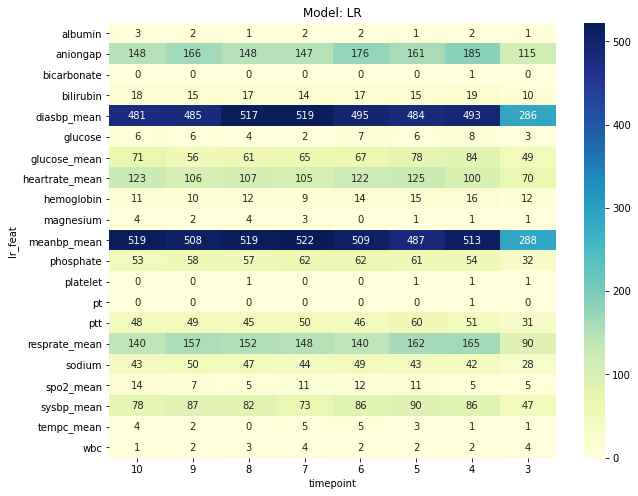

In [146]:
rank_heatmap(ranks1, model='lr')

In [147]:
weights = {'mlp': 0.81, 'rf': 0.81, 'lr': 0.71}
consensus1 = mg.magec_consensus(ranks1, use_weights=True, weights=weights)

In [148]:
consensus1.head()

,case,timepoint,winner,score,consensus,models,avg_percent_consensus,avg_percent_all
0,4,26,heartrate_mean,0.803554,2,"[lr, mlp]",31.999926,22.309090
1,4,25,heartrate_mean,0.415262,1,[lr],14.219160,-2.162241
2,4,24,albumin,0.380790,2,"[mlp, rf]",29.290979,18.225502
3,4,23,albumin,0.296498,1,[rf],32.115309,18.141674
4,4,22,albumin,0.527724,2,"[mlp, rf]",34.104005,21.327706


In [154]:
def consensus_heatmap(consensus, timepoint=10):
    f, ax = plt.subplots(figsize=(10, 8))
    data = consensus[consensus['timepoint'] <= timepoint]
    heat = data[['case','timepoint','winner']].\
               groupby(['timepoint','winner'])['case'].\
               count().reset_index(name="count")
    heat = heat.pivot(index='winner', columns='timepoint', values='count')
    ax = sns.heatmap(heat.fillna(0), cmap="YlGnBu", annot=True, fmt='.0f',)
    ax.set_title('Consensus')
    ax.invert_xaxis()
    return

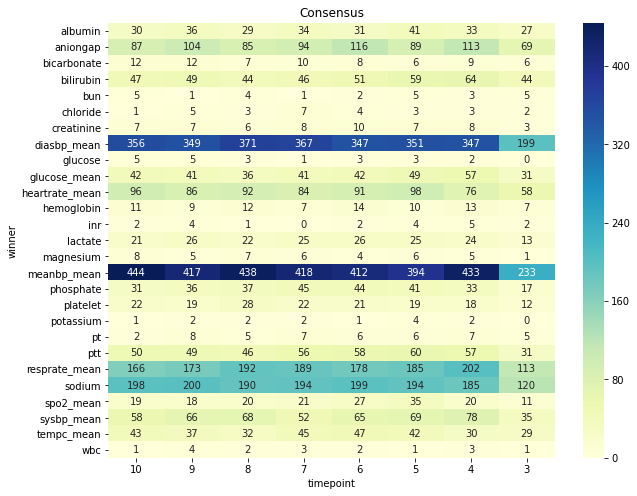

In [155]:
consensus_heatmap(consensus1)